Spatial Filter做法(Laplacian filter)

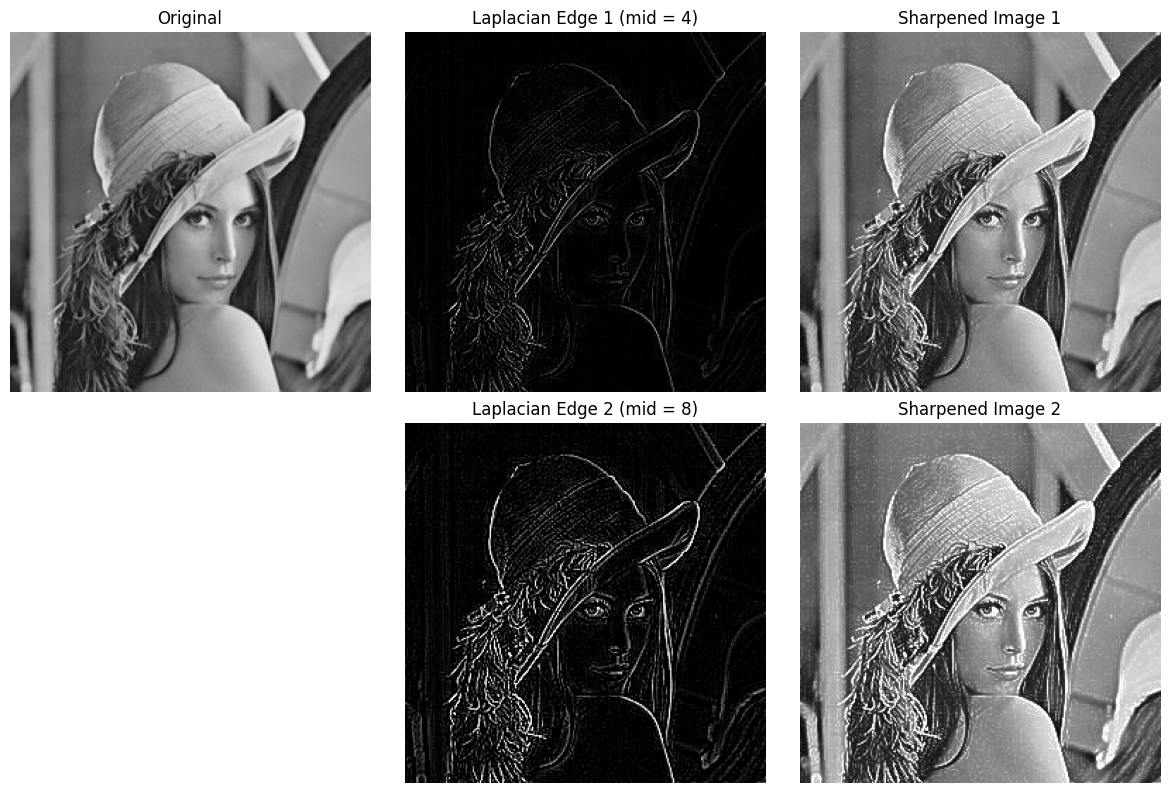

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 讀取圖像（轉為灰階）
img = cv2.imread('len_std.jpg', cv2.IMREAD_GRAYSCALE)

# 定義 Laplacian 核心
laplacian_kernel = np.array([
    [0, -1,  0],
    [-1, 4, -1],
    [0, -1,  0]
], dtype=np.float32)

laplacian_kernel_2 = np.array([
    [-1, -1,  -1],
    [-1, 8, -1],
    [-1, -1,  -1]
], dtype=np.float32)

# 套用 Laplacian filter（邊緣圖）
laplacian_edge = cv2.filter2D(img, -1, laplacian_kernel)
laplacian_edge_2 = cv2.filter2D(img, -1, laplacian_kernel_2)

# 做銳化：原圖 + 邊緣圖
sharpened = cv2.add(img, laplacian_edge)
sharpened_2 = cv2.add(img, laplacian_edge_2)

# 顯示結果
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("Laplacian Edge 1 (mid = 4)")
plt.imshow(laplacian_edge, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title("Sharpened Image 1")
plt.imshow(sharpened, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title("Laplacian Edge 2 (mid = 8)")
plt.imshow(laplacian_edge_2, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title("Sharpened Image 2")
plt.imshow(sharpened_2, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 儲存 Laplacian 邊緣圖和銳化後的圖像
cv2.imwrite('laplacian_edge_1(mid=4).jpg', laplacian_edge)
cv2.imwrite('laplacian_edge_2(mid=8).jpg', laplacian_edge_2)
cv2.imwrite('sharpened_1.jpg', sharpened)
cv2.imwrite('sharpened_2.jpg', sharpened_2)

Deep learning做法(採用realesrgan)
> 使用Python檔inference失敗(torchvision版本不相容)

In [29]:
%cd "D:\DIP-HW\HW3\Real-ESRGAN"
%run inference_realesrgan.py -i ../len_std.jpg -o ../gan_out_py.jpg --face_enhance --ext auto --fp32

D:\DIP-HW\HW3\Real-ESRGAN


ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'

使用exe檔執行(成功)

In [33]:
%cd "D:\DIP-HW\HW3\realesrgan"
!realesrgan-ncnn-vulkan.exe -i ../len_std.jpg -o ../gan_out.jpg -n realesrgan-x4plus -f jpg

D:\DIP-HW\HW3\realesrgan


[0 NVIDIA GeForce RTX 5070]  queueC=2[8]  queueG=0[16]  queueT=1[2]
[0 NVIDIA GeForce RTX 5070]  bugsbn1=0  bugbilz=0  bugcopc=0  bugihfa=0
[0 NVIDIA GeForce RTX 5070]  fp16-p/s/a=1/1/1  int8-p/s/a=1/1/1
[0 NVIDIA GeForce RTX 5070]  subgroup=32  basic=1  vote=1  ballot=1  shuffle=1
[1 AMD Radeon(TM) Graphics]  queueC=1[2]  queueG=0[1]  queueT=2[1]
[1 AMD Radeon(TM) Graphics]  bugsbn1=0  bugbilz=0  bugcopc=0  bugihfa=0
[1 AMD Radeon(TM) Graphics]  fp16-p/s/a=1/1/1  int8-p/s/a=1/1/1
[1 AMD Radeon(TM) Graphics]  subgroup=64  basic=1  vote=1  ballot=1  shuffle=1
0.00%
25.00%
50.00%
75.00%
